<a href="https://colab.research.google.com/github/maximmillion/ConvCancer/blob/main/PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
transform = {
        'train': transforms.Compose([
            transforms.Resize([128,128]), # Resizing the image as the VGG only take 224 x 244 as input size
            transforms.RandomHorizontalFlip(), # Flip the data horizontally
            #TODO if it is needed, add the random crop
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ]),
        'test': transforms.Compose([
            transforms.Resize([128,128]),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ])
    }

dataset = ImageFolder('/content/drive/MyDrive/cancer_dataG', transform=transform['train'])

In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 750
    Root location: /content/drive/MyDrive/cancer_dataG
    StandardTransform
Transform: Compose(
               Resize(size=[128, 128], interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
trainset, testset = torch.utils.data.random_split(dataset, [700, 50])

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                          shuffle=True, num_workers=2)

Feature batch shape: torch.Size([32, 3, 128, 128])
Labels batch shape: torch.Size([32])


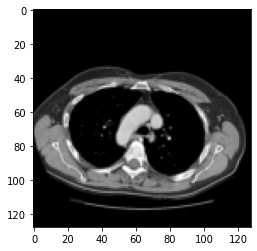

Label: 1


In [ ]:
features, labels = next(iter(trainloader))
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")
img = features[0].squeeze()
label = labels[0]
plt.imshow(img[0,:,:], cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

'''
net = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.MaxPool2d(2, 2),
            nn.Linear(13456, 120), # 16 * 5 * 5
            nn.Linear(120, 84),
            nn.Linear(84, 3),
        )

'''
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 6, kernel_size = 5)
        # stride = 1 padding =0
        # Hout = (Hin + 2*p-(K-1)-1)/s + 1
        # Hout = (128 + 2*0 - (5-1)-1)/1 + 1 = 124
        # (124,124,6)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        # Hout = (Hin + 2*p-(K-1)-1)/s + 1
        # Hout = (124 + 2*0 - (2-1)-1)/2 + 1 = 62
        # (62,62,6)
        #self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size = 5)
        # Hout = (Hin + 2*p-(K-1)-1)/s + 1
        # Hout = (62 + 2*0 - (5-1)-1)/1 + 1 = 58
        # (58,58,16)

        # Another pooling
        # Hout = (58 + 2*0 - (2-1)-1)/2 + 1 = 29

        self.fc1 = nn.Linear(23064, 120) # 16 * 5 * 5
        # (29*29*16) = 13456
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

'\nclass Net(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.conv1 = nn.Conv2d(in_channels=3, out_channels= 6, kernel_size = 5)\n        # stride = 1 padding =0\n        # Hout = (Hin + 2*p-(K-1)-1)/s + 1\n        # Hout = (128 + 2*0 - (5-1)-1)/1 + 1 = 124\n        # (124,124,6)\n        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)\n        # Hout = (Hin + 2*p-(K-1)-1)/s + 1\n        # Hout = (124 + 2*0 - (2-1)-1)/2 + 1 = 62\n        # (62,62,6)\n        #self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size = 5)\n        # Hout = (Hin + 2*p-(K-1)-1)/s + 1\n        # Hout = (62 + 2*0 - (5-1)-1)/1 + 1 = 58\n        # (58,58,16)\n\n        # Another pooling\n        # Hout = (58 + 2*0 - (2-1)-1)/2 + 1 = 29\n\n        self.fc1 = nn.Linear(23064, 120) # 16 * 5 * 5\n        # (29*29*16) = 13456\n        self.fc2 = nn.Linear(120, 84)\n        self.fc3 = nn.Linear(84, 3)\n\n    def forward(self, x):\n        x = self.pool(F.relu(self.conv1(

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
history = {'epoch':[], 'loss':[]}
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 5 == 4:    # print every 5 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss:.3f}')
            running_loss = 0.0
    
    history['epoch'].append(epoch+1)
    history['loss'].append(running_loss)

print('Finished Training')


RuntimeError: ignored

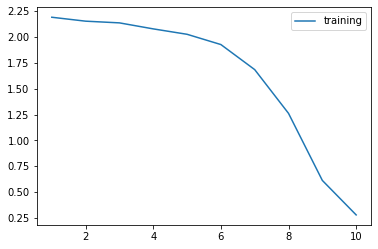

In [ ]:
plt.plot(history['epoch'], history['loss'], label='training')
plt.legend()
plt.show()

Feature batch shape: torch.Size([32, 3, 128, 128])
Labels batch shape: torch.Size([32])


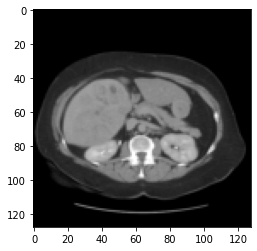

Label: 2


In [ ]:
features, labels = next(iter(testloader))
print(f"Feature batch shape: {features.size()}")
print(f"Labels batch shape: {labels.size()}")
img = features[0].squeeze()
label = labels[0]
plt.imshow(img[0,:,:], cmap="gray")
plt.show()
print(f"Label: {label}")

In [ ]:
outputs = net(features)

torch.Size([32, 13456])


In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{predicted[j]}'
                              for j in range(4)))

Predicted:  2 2 0 2


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

torch.Size([32, 13456])
torch.Size([18, 13456])
Accuracy of the network on the 10000 test images: 82 %


In [ ]:
classes = (0, 1, 2)
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname} is {accuracy:.1f} %')

torch.Size([32, 13456])
torch.Size([18, 13456])
Accuracy for class: 0 is 100.0 %
Accuracy for class: 1 is 75.0 %
Accuracy for class: 2 is 71.4 %
